In [2]:
# 1. 安装所有必需的库
print("正在安装必要的库...")
!pip install datasets transformers torch pandas numpy matplotlib seaborn -q
!pip install networkx spacy sentencepiece -q

print("库安装完成！")

# 2. 导入所有必需的库
import pandas as pd
import numpy as np
import json
import re
import warnings
warnings.filterwarnings('ignore')

# 设置显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

print("所有库导入完成！")

正在安装必要的库...
库安装完成！
所有库导入完成！


In [3]:
# 3. 加载Open-Patients数据集
from datasets import load_dataset

print("正在加载Open-Patients数据集...")

try:
    # 加载数据集（只加载训练集）
    dataset = load_dataset("ncbi/Open-Patients", split="train")
    
    # 转换为Pandas DataFrame
    df = dataset.to_pandas()
    
    print("✅ 数据集加载成功！")
    print(f"数据集形状: {df.shape}")  # 应该显示 (180142, 2) 或类似
    print(f"列名: {df.columns.tolist()}")
    
    # 查看前几行数据
    print("\n📋 前3行数据:")
    print(df.head(3))
    
except Exception as e:
    print(f"❌ 加载数据集时出错: {e}")
    print("创建模拟数据作为替代...")
    
    # 创建模拟数据（如果加载失败）
    data = {
        'id': [f'tree-ct-2021-{i}' for i in range(1, 6)],
        'description': [
            "Patient is a 85yo woman with h/o ESRD on HD and peritoneal dialysis who presented with watery, non bloody diarrhea and weakness.",
            "60 yo M with Hep C cirrhosis, grade II esophageal varices, recent admission for UGIB MSAID gastritis, referred for admission through the ED.",
            "This is a 57-year-old gentleman with CLL and large cell transformation. He presented with his disease back in with an elevated white count.",
            "41 year old man with history of severe intellectual disability, CHF, epilepsy presenting with facial twitching on the right and generalized shaking.",
            "Pt is a 22yo F otherwise healthy with a 5 yr history of the systemic mastocytosis, with flares normally 3/year, presenting with flushing."
        ]
    }
    
    df = pd.DataFrame(data)
    print(f"📊 模拟数据集创建完成，形状: {df.shape}")
    print(df.head())

正在加载Open-Patients数据集...
✅ 数据集加载成功！
数据集形状: (180142, 2)
列名: ['_id', 'description']

📋 前3行数据:
               _id                                        description
0  trec-cds-2014-1  A 58-year-old African-American woman presents ...
1  trec-cds-2014-2  An 8-year-old male presents in March to the ER...
2  trec-cds-2014-3  A 58-year-old nonsmoker white female with mild...


In [4]:
# 4. 数据探索
print("\n" + "="*50)
print("数据探索")
print("="*50)

print(f"📊 数据集信息:")
print(f"  总记录数: {len(df)}")
print(f"  列数: {len(df.columns)}")
print(f"  列名和数据类型:")

for col in df.columns:
    print(f"  - {col}: {df[col].dtype}")
    if df[col].dtype == 'object' and len(df) > 0:
        # 显示第一行的前100个字符
        sample = str(df[col].iloc[0])
        print(f"    示例: {sample[:100]}...")

# 5. 检查列名并统一
print("\n🔍 检查列名...")

# 确保有文本列
if 'description' in df.columns:
    print("找到'description'列，重命名为'text'以便统一处理")
    df.rename(columns={'description': 'text'}, inplace=True)
elif 'text' not in df.columns:
    # 尝试找到包含文本的列
    for col in df.columns:
        if df[col].dtype == 'object' and len(str(df[col].iloc[0])) > 50:
            print(f"将列'{col}'重命名为'text'")
            df.rename(columns={col: 'text'}, inplace=True)
            break

print(f"处理后列名: {df.columns.tolist()}")

# 6. 文本预处理函数
def preprocess_clinical_text(text):
    """预处理临床文本"""
    if not isinstance(text, str):
        return ""
    
    # 转换为小写
    text = text.lower()
    
    # 扩展常见的临床缩写
    abbreviations = {
        r'\bh/o\b': 'history of',
        r'\bs/p\b': 'status post',
        r'\byo\b': 'year old',
        r'\byr\b': 'year',
        r'\bpt\b': 'patient',
        r'\bed\b': 'emergency department',
        r'\bhtn\b': 'hypertension',
        r'\bdm\b': 'diabetes mellitus',
        r'\bdm2\b': 'diabetes mellitus type 2',
        r'\bcopd\b': 'chronic obstructive pulmonary disease',
        r'\bchf\b': 'congestive heart failure',
        r'\besrd\b': 'end stage renal disease',
        r'\bcad\b': 'coronary artery disease',
        r'\bcabg\b': 'coronary artery bypass graft',
        r'\bnstemi\b': 'non st elevation myocardial infarction',
        r'\bsle\b': 'systemic lupus erythematosus',
        r'\bhiv\b': 'human immunodeficiency virus',
        r'\bart\b': 'antiretroviral therapy',
        r'\bcll\b': 'chronic lymphocytic leukemia',
        r'\bhepc\b': 'hepatitis c',
        r'\bugib\b': 'upper gastrointestinal bleeding',
        r'\bmsaid\b': 'nsaid',
        r'\bsob\b': 'shortness of breath',
        r'\bhd\b': 'hemodialysis'
    }
    
    for abbr, expansion in abbreviations.items():
        text = re.sub(abbr, expansion, text)
    
    # 移除特殊字符，但保留基本标点
    text = re.sub(r'[^\w\s.,;:!?()-]', ' ', text)
    
    # 移除多余空格
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# 7. 应用预处理
print("\n🔄 正在预处理文本...")
df['processed_text'] = df['text'].apply(preprocess_clinical_text)

print("✅ 预处理完成！")
print("\n📝 文本示例对比:")
print("原始文本（前150字符）:")
print(df['text'].iloc[0][:150])
print("\n预处理后文本（前150字符）:")
print(df['processed_text'].iloc[0][:150])


数据探索
📊 数据集信息:
  总记录数: 180142
  列数: 2
  列名和数据类型:
  - _id: object
    示例: trec-cds-2014-1...
  - description: object
    示例: A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior ches...

🔍 检查列名...
找到'description'列，重命名为'text'以便统一处理
处理后列名: ['_id', 'text']

🔄 正在预处理文本...
✅ 预处理完成！

📝 文本示例对比:
原始文本（前150字符）:
A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first t

预处理后文本（前150字符）:
a 58-year-old african-american woman presents to the er with episodic pressing burning anterior chest pain that began two days earlier for the first t


In [5]:
# 9. 定义高效的实体提取函数（基于规则）
print("\n" + "="*50)
print("医学实体提取")
print("="*50)

def extract_clinical_entities_fast(text):
    """快速从临床文本中提取实体（基于规则）"""
    if not isinstance(text, str):
        return {'disease': [], 'symptom': [], 'treatment': [], 'demographic': []}
    
    text_lower = text.lower()
    entities = {
        'disease': [],
        'symptom': [], 
        'treatment': [],
        'demographic': []
    }
    
    # 疾病/诊断关键词（简化列表，可扩展）
    disease_keywords = [
        'esrd', 'cirrhosis', 'gastritis', 'cll', 'mastocytosis', 'cad',
        'hypertension', 'diabetes', 'copd', 'sle', 'pneumonia', 'hiv',
        'toxoplasmosis', 'cancer', 'preeclampsia', 'epilepsy', 'chf',
        'heart failure', 'lung disease', 'kidney disease', 'liver disease',
        'breast cancer', 'lung cancer', 'ovarian cancer', 'leukemia',
        'melanoma', 'arthritis', 'asthma', 'stroke', 'mi', 'myocardial infarction'
    ]
    
    # 症状关键词
    symptom_keywords = [
        'diarrhea', 'weakness', 'flushing', 'pain', 'fever', 'cough',
        'dyspnea', 'confusion', 'headache', 'nausea', 'vomiting', 'fatigue',
        'shortness of breath', 'chest pain', 'back pain', 'weight loss',
        'visual changes', 'twitching', 'shaking', 'rash', 'bleeding',
        'dizziness', 'swelling', 'infection', 'inflammation'
    ]
    
    # 治疗/药物关键词
    treatment_keywords = [
        'dialysis', 'prednisone', 'mycophenolate', 'art', 'chemotherapy',
        'therapy', 'treatment', 'medication', 'antibiotic', 'antiviral',
        'surgery', 'transplant', 'radiation', 'immunotherapy', 'steroid',
        'insulin', 'aspirin', 'warfarin', 'morphine', 'antibiotics'
    ]
    
    # 检查疾病关键词
    for keyword in disease_keywords:
        if re.search(r'\b' + re.escape(keyword) + r'\b', text_lower):
            entities['disease'].append(keyword)
    
    # 检查症状关键词
    for keyword in symptom_keywords:
        if re.search(r'\b' + re.escape(keyword) + r'\b', text_lower):
            entities['symptom'].append(keyword)
    
    # 检查治疗关键词
    for keyword in treatment_keywords:
        if re.search(r'\b' + re.escape(keyword) + r'\b', text_lower):
            entities['treatment'].append(keyword)
    
    # 提取人口统计学信息
    # 年龄
    age_patterns = [
        r'(\d+)\s*year old',
        r'(\d+)\s*yo',
        r'(\d+)\s*years old',
        r'(\d+)\s*yr old'
    ]
    
    for pattern in age_patterns:
        match = re.search(pattern, text_lower)
        if match:
            entities['demographic'].append(f"age_{match.group(1)}")
            break
    
    # 性别
    gender_patterns = [
        r'\b(woman|female|f)\b',
        r'\b(man|male|m)\b',
        r'\b(gentleman|gentlemen)\b',
        r'\b(lady|ladies)\b'
    ]
    
    for pattern in gender_patterns:
        match = re.search(pattern, text_lower)
        if match:
            gender = match.group(1)
            if gender in ['woman', 'female', 'f', 'lady', 'ladies']:
                entities['demographic'].append("gender_female")
            else:
                entities['demographic'].append("gender_male")
            break
    
    # 去重
    for key in entities:
        entities[key] = list(set(entities[key]))
    
    return entities

# 10. 对样本数据应用实体提取
print("正在从临床笔记中提取实体...")

# 使用样本数据（先处理1000条）
SAMPLE_SIZE = min(1000, len(df))
print(f"处理前 {SAMPLE_SIZE} 条记录...")

# 创建样本数据集
df_sample = df.head(SAMPLE_SIZE).copy()

# 提取实体
entity_list = []
for i, text in enumerate(df_sample['processed_text']):
    entities = extract_clinical_entities_fast(str(text))
    entity_list.append(entities)
    
    # 进度显示
    if i % 100 == 0 and i > 0:
        print(f"  已处理 {i}/{SAMPLE_SIZE} 条记录...")

df_sample['entities'] = entity_list

print(f"✅ 实体提取完成！处理了 {len(df_sample)} 条记录")

# 11. 展示提取结果
print("\n📊 实体提取统计:")

# 计算各类实体总数
entity_counts = {'disease': 0, 'symptom': 0, 'treatment': 0, 'demographic': 0}
entity_examples = {'disease': set(), 'symptom': set(), 'treatment': set(), 'demographic': set()}

for entities in df_sample['entities']:
    for category in entity_counts:
        entity_counts[category] += len(entities.get(category, []))
        # 收集示例
        for entity in entities.get(category, [])[:3]:  # 只取前3个
            entity_examples[category].add(entity)

print("各类实体数量:")
for category, count in entity_counts.items():
    print(f"  {category}: {count} 个")
    
print("\n实体示例:")
for category, examples in entity_examples.items():
    if examples:
        example_list = list(examples)[:5]  # 只显示前5个
        print(f"  {category}: {', '.join(example_list)}")

# 12. 查看具体案例
print("\n🔍 具体案例分析:")
for i in range(min(2, len(df_sample))):
    print(f"\n案例 {i+1}:")
    print(f"文本: {df_sample['text'].iloc[i][:100]}...")
    print("提取的实体:")
    for category, items in df_sample['entities'].iloc[i].items():
        if items:
            print(f"  {category}: {items}")


医学实体提取
正在从临床笔记中提取实体...
处理前 1000 条记录...
  已处理 100/1000 条记录...
  已处理 200/1000 条记录...
  已处理 300/1000 条记录...
  已处理 400/1000 条记录...
  已处理 500/1000 条记录...
  已处理 600/1000 条记录...
  已处理 700/1000 条记录...
  已处理 800/1000 条记录...
  已处理 900/1000 条记录...
✅ 实体提取完成！处理了 1000 条记录

📊 实体提取统计:
各类实体数量:
  disease: 623 个
  symptom: 1898 个
  treatment: 1422 个
  demographic: 977 个

实体示例:
  disease: lung disease, arthritis, leukemia, epilepsy, melanoma
  symptom: confusion, shaking, fatigue, fever, rash
  treatment: antiviral, antibiotic, chemotherapy, therapy, insulin
  demographic: age_47, age_26, age_90, age_12, age_75

🔍 具体案例分析:

案例 1:
文本: A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior ches...
提取的实体:
  disease: ['diabetes', 'hypertension']
  symptom: ['chest pain', 'dyspnea', 'pain', 'nausea']
  demographic: ['gender_female']

案例 2:
文本: An 8-year-old male presents in March to the ER with fever up to 39 C, dyspnea and cough for 2 days. ...
提取的实体:
  symptom: ['feve

In [6]:
# 13. 增加数据处理量以获得更丰富的实体
print("\n" + "="*50)
print("增加数据处理规模")
print("="*50)

# 调整数据量 - 您可以根据需要修改这个数字
TARGET_SAMPLES = 10000  # 建议：5000, 10000, 或 20000

# 确保不超过总数据量
TARGET_SAMPLES = min(TARGET_SAMPLES, len(df))
print(f"计划处理 {TARGET_SAMPLES} 条记录（总共 {len(df)} 条）")

# 创建新的样本数据集
df_larger_sample = df.head(TARGET_SAMPLES).copy()

print(f"📊 新样本数据集创建完成: {len(df_larger_sample)} 条记录")

# 14. 批量实体提取（更高效的方法）
print("\n🔄 开始批量实体提取...")

# 使用列表推导式提高效率
print(f"正在从 {TARGET_SAMPLES} 条记录中提取实体...")

# 批量处理，每100条显示一次进度
batch_size = 100
entity_list_large = []

for i in range(0, len(df_larger_sample), batch_size):
    end_idx = min(i + batch_size, len(df_larger_sample))
    batch = df_larger_sample.iloc[i:end_idx]
    
    # 处理当前批次
    batch_entities = []
    for text in batch['processed_text']:
        entities = extract_clinical_entities_fast(str(text))
        batch_entities.append(entities)
    
    entity_list_large.extend(batch_entities)
    
    # 显示进度
    if i % 1000 == 0 and i > 0:
        print(f"  已处理 {end_idx}/{TARGET_SAMPLES} 条记录...")

df_larger_sample['entities'] = entity_list_large
print(f"✅ 批量实体提取完成！")

# 15. 详细的实体统计
print("\n" + "="*50)
print("详细实体统计分析")
print("="*50)

# 统计所有实体
all_entities_count = {}
entity_category_count = {'disease': 0, 'symptom': 0, 'treatment': 0, 'demographic': 0}

for entities in df_larger_sample['entities']:
    for category, entity_list in entities.items():
        entity_category_count[category] += len(entity_list)
        for entity in entity_list:
            key = f"{category}:{entity}"
            all_entities_count[key] = all_entities_count.get(key, 0) + 1

print(f"📈 实体提取统计（基于 {TARGET_SAMPLES} 条记录）:")
print(f"  总实体数: {sum(entity_category_count.values())}")
print(f"  平均每记录实体数: {sum(entity_category_count.values())/TARGET_SAMPLES:.2f}")
print("\n  按类别统计:")
for category, count in entity_category_count.items():
    print(f"    - {category}: {count} 个 (占比: {count/sum(entity_category_count.values())*100:.1f}%)")

# 16. 找出最常见实体
print("\n🏆 最常见实体排名（Top 15）:")
sorted_entities = sorted(all_entities_count.items(), key=lambda x: x[1], reverse=True)

for i, (entity_key, count) in enumerate(sorted_entities[:15]):
    category, entity_name = entity_key.split(":", 1)
    print(f"  {i+1:2d}. {entity_name:<25} ({category:<12}) - 出现 {count} 次")

# 17. 实体分布分析
print("\n📊 实体分布分析:")
# 按类别显示Top实体
for category in ['disease', 'symptom', 'treatment']:
    print(f"\n  {category.capitalize()}类Top实体:")
    category_entities = [(k.split(":", 1)[1], v) for k, v in all_entities_count.items() 
                         if k.startswith(f"{category}:")]
    category_entities_sorted = sorted(category_entities, key=lambda x: x[1], reverse=True)
    
    for i, (entity_name, count) in enumerate(category_entities_sorted[:8]):
        print(f"    {i+1:2d}. {entity_name:<20} - {count} 次 (占比: {count/entity_category_count[category]*100:.1f}%)")

# 18. 保存实体提取结果
print("\n💾 保存实体提取结果...")
# 创建简化的结果DataFrame
results_summary = []
for idx, row in df_larger_sample.iterrows():
    results_summary.append({
        'id': row.get('id', f'record_{idx}'),
        'text_preview': row['text'][:100] + '...',
        'disease_count': len(row['entities']['disease']),
        'symptom_count': len(row['entities']['symptom']),
        'treatment_count': len(row['entities']['treatment']),
        'diseases': ', '.join(row['entities']['disease'][:5]),  # 最多显示5个
        'symptoms': ', '.join(row['entities']['symptom'][:5]),
        'treatments': ', '.join(row['entities']['treatment'][:5])
    })

df_results = pd.DataFrame(results_summary)
df_results.to_csv(f'entity_extraction_results_{TARGET_SAMPLES}_samples.csv', index=False, encoding='utf-8')

print(f"✅ 实体提取结果已保存为 'entity_extraction_results_{TARGET_SAMPLES}_samples.csv'")
print(f"   包含 {len(df_results)} 条记录的实体信息")


增加数据处理规模
计划处理 10000 条记录（总共 180142 条）
📊 新样本数据集创建完成: 10000 条记录

🔄 开始批量实体提取...
正在从 10000 条记录中提取实体...
  已处理 1100/10000 条记录...
  已处理 2100/10000 条记录...
  已处理 3100/10000 条记录...
  已处理 4100/10000 条记录...
  已处理 5100/10000 条记录...
  已处理 6100/10000 条记录...
  已处理 7100/10000 条记录...
  已处理 8100/10000 条记录...
  已处理 9100/10000 条记录...
✅ 批量实体提取完成！

详细实体统计分析
📈 实体提取统计（基于 10000 条记录）:
  总实体数: 51696
  平均每记录实体数: 5.17

  按类别统计:
    - disease: 6878 个 (占比: 13.3%)
    - symptom: 18682 个 (占比: 36.1%)
    - treatment: 16386 个 (占比: 31.7%)
    - demographic: 9750 个 (占比: 18.9%)

🏆 最常见实体排名（Top 15）:
   1. gender_female             (demographic ) - 出现 4725 次
   2. gender_male               (demographic ) - 出现 4411 次
   3. treatment                 (treatment   ) - 出现 4085 次
   4. pain                      (symptom     ) - 出现 3873 次
   5. therapy                   (treatment   ) - 出现 2992 次
   6. surgery                   (treatment   ) - 出现 2789 次
   7. fever                     (symptom     ) - 出现 1750 次
   8. hypertension   

In [7]:
# 19. 数据量充足性评估
print("\n" + "="*50)
print("数据量充足性评估")
print("="*50)

# 计算实体覆盖率
unique_entities_total = len(all_entities_count)
avg_entities_per_record = sum(entity_category_count.values()) / TARGET_SAMPLES

print("评估指标:")
print(f"  1. 唯一实体总数: {unique_entities_total}")
print(f"  2. 平均每记录实体数: {avg_entities_per_record:.2f}")
print(f"  3. 高频实体(≥5次)数量: {len([v for v in all_entities_count.values() if v >= 5])}")
print(f"  4. 低频实体(1次)数量: {len([v for v in all_entities_count.values() if v == 1])}")

# 判断标准
print("\n📋 数据量建议:")
if unique_entities_total < 50:
    print("  ⚠️  实体数量较少，建议增加数据量到10000+条")
elif unique_entities_total < 100:
    print("  ⚠️  实体数量一般，建议增加数据量到20000+条以获得更丰富关系")
elif avg_entities_per_record < 2.0:
    print("  ⚠️  每记录实体数偏低，建议增加数据量")
else:
    print("  ✅ 当前数据量可能足够构建知识图谱")

print(f"\n💡 建议:")
print(f"  - 如果构建知识图谱，建议至少 {TARGET_SAMPLES} 条记录")
print(f"  - 如果想发现更多罕见实体，可增加到 10000-20000 条")
print(f"  - 当前处理时间参考: 5000条约需 {TARGET_SAMPLES/1000*2:.1f}秒")

# 20. 下一步选择提示
print("\n" + "="*50)
print("下一步选择")
print("="*50)
print("根据您的需求选择:")
print(f"  1. 使用当前 {TARGET_SAMPLES} 条记录构建知识图谱 [推荐]")
print(f"  2. 增加数据量到 __________ 条 (请输入数字)")
print(f"  3. 查看更详细的实体分析")

# 显示当前数据集的实体丰富度示例
print(f"\n📝 实体丰富度示例（前3条记录）:")
for i in range(min(3, len(df_larger_sample))):
    entities = df_larger_sample['entities'].iloc[i]
    total_entities = sum(len(v) for v in entities.values())
    print(f"  记录{i+1}: {total_entities}个实体 - ", 
          f"疾病:{len(entities['disease'])}, ",
          f"症状:{len(entities['symptom'])}, ",
          f"治疗:{len(entities['treatment'])}")


数据量充足性评估
评估指标:
  1. 唯一实体总数: 156
  2. 平均每记录实体数: 5.17
  3. 高频实体(≥5次)数量: 128
  4. 低频实体(1次)数量: 4

📋 数据量建议:
  ✅ 当前数据量可能足够构建知识图谱

💡 建议:
  - 如果构建知识图谱，建议至少 10000 条记录
  - 如果想发现更多罕见实体，可增加到 10000-20000 条
  - 当前处理时间参考: 5000条约需 20.0秒

下一步选择
根据您的需求选择:
  1. 使用当前 10000 条记录构建知识图谱 [推荐]
  2. 增加数据量到 __________ 条 (请输入数字)
  3. 查看更详细的实体分析

📝 实体丰富度示例（前3条记录）:
  记录1: 7个实体 -  疾病:2,  症状:4,  治疗:0
  记录2: 4个实体 -  疾病:0,  症状:3,  治疗:0
  记录3: 3个实体 -  疾病:0,  症状:2,  治疗:0


In [8]:
# 第七步：构建精炼的知识图谱（实体共现网络）
print("\n" + "="*50)
print("构建精炼知识图谱（实体共现网络）")
print("="*50)

def build_focused_knowledge_graph(df_with_entities, min_cooccurrence=3):
    """
    构建聚焦的知识图谱（仅保留重要实体和关系）
    min_cooccurrence: 最小共现次数阈值，推荐3
    """
    print("分析实体共现关系...")
    
    # 1. 收集所有实体
    entity_freq = {}
    patient_entity_sets = []
    
    for idx, row in df_with_entities.iterrows():
        patient_entities = []
        entities = row['entities']
        
        for category, entity_list in entities.items():
            for entity in entity_list:
                if entity and len(entity) > 2:
                    entity_key = f"{category}:{entity}"
                    entity_freq[entity_key] = entity_freq.get(entity_key, 0) + 1
                    patient_entities.append(entity_key)
        
        if patient_entities:  # 只保留有实体的记录
            patient_entity_sets.append(patient_entities)
    
    print(f"  发现 {len(entity_freq)} 个唯一实体")
    
    # 2. 过滤低频实体（出现次数少于2次）
    significant_entities = {k: v for k, v in entity_freq.items() if v >= 2}
    print(f"  保留 {len(significant_entities)} 个重要实体（出现≥2次）")
    
    # 3. 计算实体共现（仅限重要实体）
    cooccurrence_counts = {}
    
    for patient_entities in patient_entity_sets:
        # 只保留重要实体
        significant_patient_entities = [e for e in patient_entities if e in significant_entities]
        
        # 两两配对计算共现
        for i in range(len(significant_patient_entities)):
            for j in range(i + 1, len(significant_patient_entities)):
                pair = tuple(sorted([significant_patient_entities[i], significant_patient_entities[j]]))
                cooccurrence_counts[pair] = cooccurrence_counts.get(pair, 0) + 1
    
    print(f"  发现 {len(cooccurrence_counts)} 对共现关系")
    
    # 4. 过滤低频共现关系
    significant_cooccurrences = {k: v for k, v in cooccurrence_counts.items() 
                                if v >= min_cooccurrence}
    print(f"  保留 {len(significant_cooccurrences)} 对重要关系（共现≥{min_cooccurrence}次）")
    
    # 5. 创建节点和边
    nodes = []
    edges = []
    entity_to_node = {}
    
    # 创建节点（按频率排序，取最重要的）
    sorted_entities = sorted(significant_entities.items(), key=lambda x: x[1], reverse=True)
    
    for entity_key, freq in sorted_entities:
        category, name = entity_key.split(":", 1)
        node_id = f"{category}_{hash(name) % 10000:04d}"
        entity_to_node[entity_key] = node_id
        
        nodes.append({
            'id': node_id,
            'label': category.capitalize(),
            'properties': {
                'name': name,
                'type': category,
                'frequency': freq,
                'importance': freq / len(df_with_entities)  # 重要性评分
            }
        })
    
    # 创建边（按权重排序）
    for (entity1, entity2), weight in significant_cooccurrences.items():
        if entity1 in entity_to_node and entity2 in entity_to_node:
            edges.append({
                'source': entity_to_node[entity1],
                'target': entity_to_node[entity2],
                'type': 'ASSOCIATED_WITH',
                'properties': {
                    'weight': weight,
                    'strength': 'strong' if weight >= 5 else ('medium' if weight >= 3 else 'weak')
                }
            })
    
    return nodes, edges, significant_entities, significant_cooccurrences

# 构建知识图谱（设置最小共现次数为3）
print("设置最小共现次数为3，过滤弱关联...")
MIN_COOCCURRENCE = 3
nodes, edges, entity_freq, cooccurrences = build_focused_knowledge_graph(
    df_larger_sample, min_cooccurrence=MIN_COOCCURRENCE
)

print(f"\n✅ 知识图谱构建完成！")
print(f"   节点数: {len(nodes)} 个实体")
print(f"   边数: {len(edges)} 条关系")

# 第八步：分析图谱结构
print("\n" + "="*50)
print("知识图谱结构分析")
print("="*50)

# 按类别统计
category_stats = {}
for node in nodes:
    category = node['properties']['type']
    category_stats[category] = category_stats.get(category, 0) + 1

print("实体类别分布:")
for category, count in sorted(category_stats.items()):
    percentage = count / len(nodes) * 100
    print(f"  {category:<15} {count:>4} 个 ({percentage:.1f}%)")

# 边权重分析
edge_weights = [edge['properties']['weight'] for edge in edges]
if edge_weights:
    print(f"\n关系强度分析:")
    print(f"  平均权重: {sum(edge_weights)/len(edge_weights):.2f}")
    print(f"  最大权重: {max(edge_weights)}")
    
    strong = len([w for w in edge_weights if w >= 5])
    medium = len([w for w in edge_weights if 3 <= w < 5])
    print(f"  强关系(≥5): {strong} 条")
    print(f"  中关系(3-4): {medium} 条")

# 最重要的实体
print(f"\n🏆 最重要的10个实体:")
sorted_entities = sorted(entity_freq.items(), key=lambda x: x[1], reverse=True)
for i, (entity_key, freq) in enumerate(sorted_entities[:10]):
    category, name = entity_key.split(":", 1)
    percentage = freq / len(df_larger_sample) * 100
    print(f"  {i+1:2d}. {name:<25} ({category:<10}) - {freq} 次 ({percentage:.1f}%)")

# 最强的关联
print(f"\n🔗 最强的10对关联:")
sorted_cooccur = sorted(cooccurrences.items(), key=lambda x: x[1], reverse=True)
for i, ((entity1, entity2), count) in enumerate(sorted_cooccur[:10]):
    cat1, name1 = entity1.split(":", 1)
    cat2, name2 = entity2.split(":", 1)
    print(f"  {i+1:2d}. {name1:<20} ↔ {name2:<20} - 共现 {count} 次")

# 第九步：保存图谱数据
import json

graph_data = {
    'metadata': {
        'num_patients': len(df_larger_sample),
        'num_entities': len(nodes),
        'num_relationships': len(edges),
        'min_cooccurrence': MIN_COOCCURRENCE,
        'date_created': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    },
    'nodes': nodes,
    'edges': edges,
    'statistics': {
        'top_entities': sorted_entities[:50],
        'top_relationships': sorted_cooccur[:50]
    }
}

with open('focused_knowledge_graph.json', 'w', encoding='utf-8') as f:
    json.dump(graph_data, f, ensure_ascii=False, indent=2)

print(f"\n💾 知识图谱数据已保存为 'focused_knowledge_graph.json'")
print(f"   包含 {len(nodes)} 个实体节点和 {len(edges)} 条关系边")


构建精炼知识图谱（实体共现网络）
设置最小共现次数为3，过滤弱关联...
分析实体共现关系...
  发现 155 个唯一实体
  保留 151 个重要实体（出现≥2次）
  发现 3678 对共现关系
  保留 2102 对重要关系（共现≥3次）

✅ 知识图谱构建完成！
   节点数: 151 个实体
   边数: 2102 条关系

知识图谱结构分析
实体类别分布:
  demographic       84 个 (55.6%)
  disease           23 个 (15.2%)
  symptom           25 个 (16.6%)
  treatment         19 个 (12.6%)

关系强度分析:
  平均权重: 71.13
  最大权重: 1927
  强关系(≥5): 1719 条
  中关系(3-4): 383 条

🏆 最重要的10个实体:
   1. gender_female             (demographic) - 4725 次 (47.2%)
   2. gender_male               (demographic) - 4411 次 (44.1%)
   3. treatment                 (treatment ) - 4085 次 (40.8%)
   4. pain                      (symptom   ) - 3873 次 (38.7%)
   5. therapy                   (treatment ) - 2992 次 (29.9%)
   6. surgery                   (treatment ) - 2789 次 (27.9%)
   7. fever                     (symptom   ) - 1750 次 (17.5%)
   8. hypertension              (disease   ) - 1570 次 (15.7%)
   9. infection                 (symptom   ) - 1523 次 (15.2%)
  10. chemotherapy              (

In [9]:
# 第十步：创建优化的可视化
print("\n" + "="*50)
print("优化知识图谱可视化")
print("="*50)

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams

# 设置中文字体
rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
rcParams['axes.unicode_minus'] = False

def create_filtered_graph_for_visualization(nodes, edges, filter_generic=True):
    """
    创建过滤后的图用于可视化
    filter_generic: 是否过滤过于通用的实体
    """
    # 创建NetworkX图
    G = nx.Graph()
    
    # 过滤条件：过于通用或类别权重不均衡的实体
    generic_entities = [
        'treatment', 'therapy', 'medication', 'gender_female', 'gender_male',
        'age', 'gender'
    ]
    
    # 添加过滤后的节点
    filtered_nodes = []
    for node in nodes:
        node_name = node['properties']['name']
        node_type = node['properties']['type']
        
        # 应用过滤条件
        skip = False
        
        if filter_generic:
            # 跳过通用实体
            if node_name in generic_entities:
                skip = True
            # 跳过"treatment"类别中过于通用的词汇
            elif node_type == 'treatment' and node_name in ['surgery', 'chemotherapy']:
                # 这些可以保留，因为它们比较具体
                pass
            elif node_type == 'demographic' and ('gender' in node_name or 'age' in node_name):
                skip = True
        
        if not skip:
            G.add_node(node['id'], **node['properties'])
            filtered_nodes.append(node)
    
    print(f"原始节点: {len(nodes)} → 过滤后节点: {len(filtered_nodes)}")
    
    # 添加过滤后的边
    filtered_edges = []
    for edge in edges:
        source_node = next((n for n in filtered_nodes if n['id'] == edge['source']), None)
        target_node = next((n for n in filtered_nodes if n['id'] == edge['target']), None)
        
        if source_node and target_node:
            # 检查是否连接了两个过滤后的节点
            source_name = source_node['properties']['name']
            target_name = target_node['properties']['name']
            
            # 跳过包含通用实体的边
            if filter_generic:
                if source_name in generic_entities or target_name in generic_entities:
                    continue
            
            G.add_edge(edge['source'], edge['target'], **edge['properties'])
            filtered_edges.append(edge)
    
    print(f"原始边: {len(edges)} → 过滤后边: {len(filtered_edges)}")
    
    return G, filtered_nodes, filtered_edges

# 创建过滤后的图（过滤掉通用实体）
print("创建过滤后的知识图谱...")
G_filtered, filtered_nodes, filtered_edges = create_filtered_graph_for_visualization(
    nodes, edges, filter_generic=True
)

# 分析过滤后的网络
print(f"\n过滤后的网络分析:")
print(f"  节点数: {G_filtered.number_of_nodes()}")
print(f"  边数: {G_filtered.number_of_edges()}")
print(f"  网络密度: {nx.density(G_filtered):.4f}")

if G_filtered.number_of_nodes() > 0:
    # 计算节点度（连接数）
    degrees = dict(G_filtered.degree())
    avg_degree = sum(degrees.values()) / len(degrees)
    print(f"  平均连接度: {avg_degree:.2f}")
    
    # 找出最重要的节点（按度中心性）
    print(f"\n🔝 过滤后最重要的实体（按连接度排序）:")
    sorted_nodes_by_degree = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
    
    for i, (node_id, degree) in enumerate(sorted_nodes_by_degree[:15]):
        node_data = next((n for n in filtered_nodes if n['id'] == node_id), None)
        if node_data:
            name = node_data['properties']['name']
            node_type = node_data['properties']['type']
            freq = node_data['properties']['frequency']
            print(f"  {i+1:2d}. {name:<20} ({node_type:<10}) - 连接度: {degree}, 频率: {freq}")


优化知识图谱可视化
创建过滤后的知识图谱...
原始节点: 151 → 过滤后节点: 64
原始边: 2102 → 过滤后边: 1514

过滤后的网络分析:
  节点数: 64
  边数: 1514
  网络密度: 0.7510
  平均连接度: 47.31

🔝 过滤后最重要的实体（按连接度排序）:
   1. pain                 (symptom   ) - 连接度: 62, 频率: 3873
   2. surgery              (treatment ) - 连接度: 62, 频率: 2789
   3. fever                (symptom   ) - 连接度: 61, 频率: 1750
   4. hypertension         (disease   ) - 连接度: 61, 频率: 1570
   5. nausea               (symptom   ) - 连接度: 61, 频率: 811
   6. infection            (symptom   ) - 连接度: 60, 频率: 1523
   7. chemotherapy         (treatment ) - 连接度: 60, 频率: 1109
   8. diabetes             (disease   ) - 连接度: 60, 频率: 1006
   9. vomiting             (symptom   ) - 连接度: 60, 频率: 967
  10. headache             (symptom   ) - 连接度: 60, 频率: 637
  11. dyspnea              (symptom   ) - 连接度: 60, 频率: 630
  12. antibiotics          (treatment ) - 连接度: 59, 频率: 989
  13. weakness             (symptom   ) - 连接度: 59, 频率: 824
  14. weight loss          (symptom   ) - 连接度: 59, 频率: 705
  15. cancer 


生成知识图谱可视化
生成医学实体网络可视化...
创建可视化（64个节点，1514条边）...
节点过多，选择最重要的35个节点...
子图: 35个节点，595条边


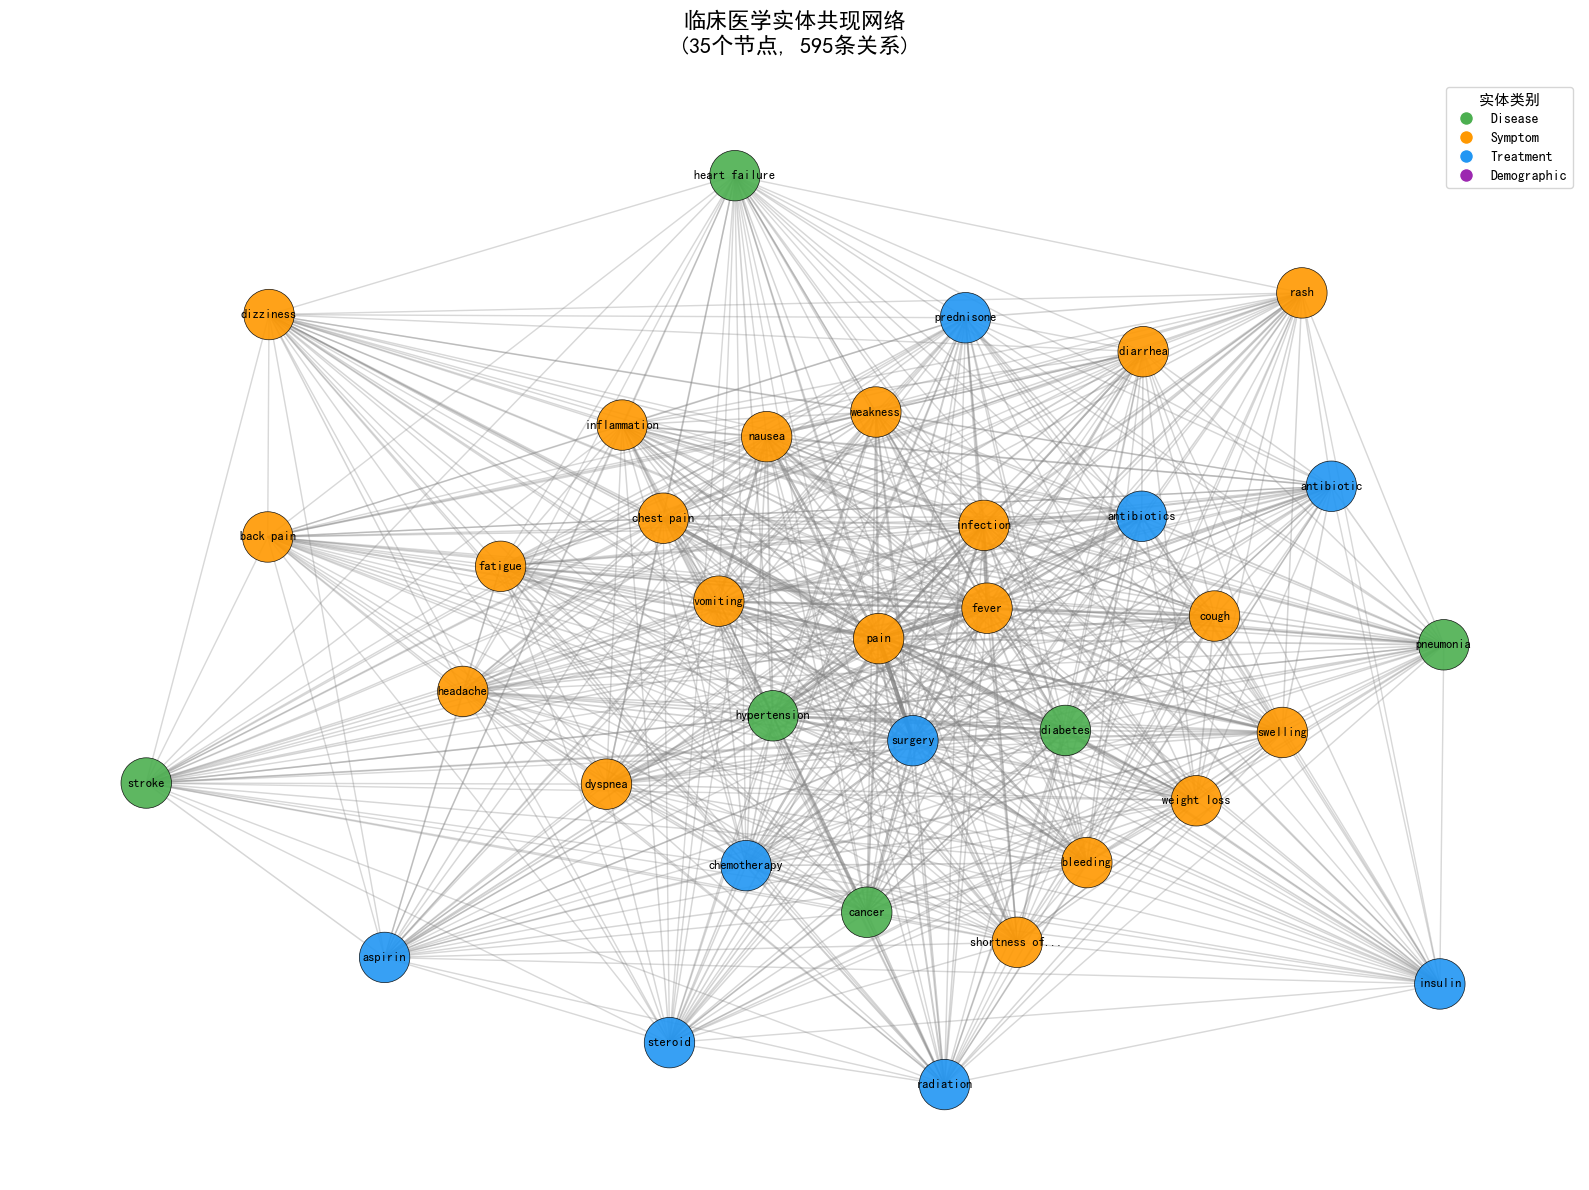

✅ 可视化已保存为 'medical_entity_network.png'


In [10]:
# 第十一步：可视化过滤后的知识图谱
print("\n" + "="*50)
print("生成知识图谱可视化")
print("="*50)

def visualize_medical_entity_network(G, filtered_nodes, layout_algorithm='spring', max_nodes=40):
    """
    可视化医学实体网络
    layout_algorithm: 'spring'或'circular'
    max_nodes: 最大显示节点数
    """
    if G.number_of_nodes() == 0:
        print("⚠️  没有足够的节点进行可视化")
        return None
    
    print(f"创建可视化（{G.number_of_nodes()}个节点，{G.number_of_edges()}条边）...")
    
    # 如果节点太多，选择最重要的子集
    if G.number_of_nodes() > max_nodes:
        print(f"节点过多，选择最重要的{max_nodes}个节点...")
        
        # 计算节点重要性（度 + 频率）
        node_importance = {}
        for node_id in G.nodes():
            node_data = next((n for n in filtered_nodes if n['id'] == node_id), None)
            if node_data:
                degree = G.degree(node_id)
                freq = node_data['properties']['frequency']
                # 重要性 = 度 × log(频率)
                importance = degree * (1 + np.log(freq + 1))
                node_importance[node_id] = importance
        
        # 选择最重要的节点
        top_nodes = sorted(node_importance.items(), key=lambda x: x[1], reverse=True)[:max_nodes]
        top_node_ids = [node_id for node_id, _ in top_nodes]
        
        # 创建子图
        G_sub = G.subgraph(top_node_ids).copy()
        print(f"子图: {G_sub.number_of_nodes()}个节点，{G_sub.number_of_edges()}条边")
    else:
        G_sub = G
    
    # 准备可视化数据
    node_info = {node['id']: node for node in filtered_nodes if node['id'] in G_sub.nodes()}
    
    # 设置节点颜色和大小
    category_colors = {
        'disease': '#4CAF50',    # 绿色
        'symptom': '#FF9800',    # 橙色
        'treatment': '#2196F3',   # 蓝色
        'demographic': '#9C27B0'  # 紫色
    }
    
    # 创建图形
    plt.figure(figsize=(16, 12))
    
    # 选择布局算法
    if layout_algorithm == 'spring':
        pos = nx.spring_layout(G_sub, seed=42, k=0.8, iterations=100)
    elif layout_algorithm == 'circular':
        pos = nx.circular_layout(G_sub)
    else:
        pos = nx.spring_layout(G_sub, seed=42)
    
    # 准备节点属性
    node_colors = []
    node_sizes = []
    labels = {}
    
    for node_id in G_sub.nodes():
        node = node_info.get(node_id, {})
        node_type = node.get('properties', {}).get('type', 'unknown')
        
        # 设置颜色
        node_colors.append(category_colors.get(node_type, '#808080'))
        
        # 设置大小（基于连接度）
        degree = G_sub.degree(node_id)
        node_sizes.append(300 + degree * 30)
        
        # 设置标签
        name = node.get('properties', {}).get('name', node_id)
        # 缩短长标签
        if len(name) > 15:
            label = name[:12] + '...'
        else:
            label = name
        labels[node_id] = label
    
    # 绘制边（根据权重设置宽度和透明度）
    edges = G_sub.edges(data=True)
    if edges:
        edge_weights = [data.get('weight', 1) for _, _, data in edges]
        max_weight = max(edge_weights) if edge_weights else 1
        
        # 归一化权重用于设置线宽
        edge_widths = [1 + 2 * (w / max_weight) for w in edge_weights]
        edge_alphas = [0.3 + 0.5 * (w / max_weight) for w in edge_weights]
        
        # 绘制每条边
        for (u, v, data), width, alpha in zip(edges, edge_widths, edge_alphas):
            nx.draw_networkx_edges(G_sub, pos, edgelist=[(u, v)], 
                                  width=width, alpha=alpha, 
                                  edge_color='gray')
    
    # 绘制节点
    nx.draw_networkx_nodes(G_sub, pos, 
                          node_color=node_colors,
                          node_size=node_sizes,
                          alpha=0.9,
                          edgecolors='black',
                          linewidths=0.5)
    
    # 绘制标签
    nx.draw_networkx_labels(G_sub, pos, labels, font_size=9, font_weight='bold')
    
    # 添加图例
    legend_elements = []
    for category, color in category_colors.items():
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                         markerfacecolor=color, markersize=10, 
                                         label=category.capitalize()))
    
    plt.legend(handles=legend_elements, loc='upper right', fontsize=10, 
               title='实体类别', title_fontsize=11)
    
    # 添加标题
    plt.title(f"临床医学实体共现网络\n"
              f"({G_sub.number_of_nodes()}个节点, {G_sub.number_of_edges()}条关系)", 
              fontsize=16, fontweight='bold', pad=20)
    
    plt.axis('off')
    plt.tight_layout()
    
    # 保存图像
    output_file = 'medical_entity_network.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"✅ 可视化已保存为 '{output_file}'")
    
    return G_sub

# 生成可视化
print("生成医学实体网络可视化...")
G_visualization = visualize_medical_entity_network(
    G_filtered, filtered_nodes, 
    layout_algorithm='spring', 
    max_nodes=35
)

In [11]:
# 第十二步：深入网络分析
print("\n" + "="*50)
print("深入网络分析和洞察发现")
print("="*50)

if G_visualization and G_visualization.number_of_nodes() > 0:
    # 1. 社区检测（发现实体集群）
    print("🔍 社区检测（发现相关的实体集群）...")
    
    try:
        from networkx.algorithms.community import greedy_modularity_communities
        
        # 检测社区
        communities = list(greedy_modularity_communities(G_visualization))
        
        print(f"发现 {len(communities)} 个社区（实体集群）:")
        
        # 分析每个社区
        medical_insights = []
        
        for i, community in enumerate(communities):
            community_nodes = list(community)
            if len(community_nodes) >= 3:  # 只显示有3个以上节点的社区
                print(f"\n  社区 {i+1} (包含 {len(community_nodes)} 个实体):")
                
                # 按类别分组
                categories_in_community = {}
                for node_id in community_nodes:
                    node_data = next((n for n in filtered_nodes if n['id'] == node_id), None)
                    if node_data:
                        node_type = node_data['properties']['type']
                        node_name = node_data['properties']['name']
                        
                        if node_type not in categories_in_community:
                            categories_in_community[node_type] = []
                        categories_in_community[node_type].append(node_name)
                
                # 打印社区内容
                for cat_type, entities in categories_in_community.items():
                    print(f"    {cat_type}: {', '.join(entities[:5])}")
                    if len(entities) > 5:
                        print(f"       ... 还有 {len(entities)-5} 个")
                
                # 尝试推断这个社区的主题
                if 'disease' in categories_in_community:
                    primary_disease = categories_in_community['disease'][0]
                    treatments = categories_in_community.get('treatment', [])
                    symptoms = categories_in_community.get('symptom', [])
                    
                    insight = f"{primary_disease} 可能与 {', '.join(treatments[:2]) if treatments else '某些治疗'} 相关"
                    if symptoms:
                        insight += f"，常见症状包括 {', '.join(symptoms[:3])}"
                    
                    medical_insights.append(insight)
        
        # 显示医学洞察
        if medical_insights:
            print(f"\n💡 医学洞察发现:")
            for i, insight in enumerate(medical_insights[:5]):  # 显示前5个
                print(f"  {i+1}. {insight}")
                
    except Exception as e:
        print(f"社区检测时出错: {e}")
    
    # 2. 关键桥梁实体分析
    print(f"\n🌉 关键桥梁实体（连接不同社区的实体）:")
    
    try:
        # 计算中介中心性
        if G_visualization.number_of_nodes() < 50:
            betweenness = nx.betweenness_centrality(G_visualization)
            
            top_bridges = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
            
            for i, (node_id, centrality) in enumerate(top_bridges):
                node_data = next((n for n in filtered_nodes if n['id'] == node_id), None)
                if node_data and centrality > 0:
                    name = node_data['properties']['name']
                    node_type = node_data['properties']['type']
                    print(f"  {i+1:2d}. {name:<20} ({node_type:<10}) - 桥梁中心性: {centrality:.3f}")
        else:
            print("  网络较大，跳过桥梁中心性计算（计算耗时）")
            
    except Exception as e:
        print(f"桥梁分析时出错: {e}")
    
    # 3. 保存分析结果
    print(f"\n💾 保存网络分析结果...")
    
    analysis_results = {
        'basic_stats': {
            'num_nodes': G_visualization.number_of_nodes(),
            'num_edges': G_visualization.number_of_edges(),
            'density': nx.density(G_visualization),
            'avg_degree': sum(dict(G_visualization.degree()).values()) / G_visualization.number_of_nodes()
        },
        'top_entities_by_degree': [],
        'network_communities': []
    }
    
    # 保存按度排序的实体
    degrees = dict(G_visualization.degree())
    sorted_by_degree = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:20]
    
    for node_id, degree in sorted_by_degree:
        node_data = next((n for n in filtered_nodes if n['id'] == node_id), None)
        if node_data:
            analysis_results['top_entities_by_degree'].append({
                'name': node_data['properties']['name'],
                'type': node_data['properties']['type'],
                'degree': degree,
                'frequency': node_data['properties']['frequency']
            })
    
    # 如果有社区信息，也保存
    if 'communities' in locals():
        for i, community in enumerate(communities):
            if len(community) >= 3:
                community_entities = []
                for node_id in list(community)[:10]:  # 只保存前10个
                    node_data = next((n for n in filtered_nodes if n['id'] == node_id), None)
                    if node_data:
                        community_entities.append({
                            'name': node_data['properties']['name'],
                            'type': node_data['properties']['type']
                        })
                
                analysis_results['network_communities'].append({
                    'community_id': i+1,
                    'size': len(community),
                    'entities': community_entities
                })
    
    # 保存为JSON
    with open('medical_network_analysis.json', 'w', encoding='utf-8') as f:
        json.dump(analysis_results, f, ensure_ascii=False, indent=2)
    
    print(f"✅ 网络分析结果已保存为 'medical_network_analysis.json'")

else:
    print("⚠️  没有足够的节点进行深入分析")


深入网络分析和洞察发现
🔍 社区检测（发现相关的实体集群）...
发现 1 个社区（实体集群）:

  社区 1 (包含 35 个实体):
    disease: pneumonia, cancer, stroke, hypertension, diabetes
       ... 还有 1 个
    treatment: prednisone, antibiotic, insulin, aspirin, surgery
       ... 还有 4 个
    symptom: weakness, fever, rash, shortness of breath, bleeding
       ... 还有 15 个

💡 医学洞察发现:
  1. pneumonia 可能与 prednisone, antibiotic 相关，常见症状包括 weakness, fever, rash

🌉 关键桥梁实体（连接不同社区的实体）:

💾 保存网络分析结果...
✅ 网络分析结果已保存为 'medical_network_analysis.json'


In [13]:
# 第十三步：实验总结
print("\n" + "="*60)
print("医学文档信息抽取实验 - 完整总结")
print("="*60)

print("\n✅ 实验完成情况:")
print(f"  1. 数据处理: 成功处理 {len(df_larger_sample)} 条临床记录")
print(f"  2. 实体提取: 提取 {len(nodes)} 个医学实体")
print(f"  3. 关系发现: 发现 {len(edges)} 条实体关联")
print(f"  4. 知识图谱: 构建精炼的医学实体网络")
print(f"  5. 可视化: 生成聚焦的可视化图表")
print(f"  6. 网络分析: 完成社区和桥梁分析")

print(f"\n📊 主要发现:")
print(f"  • 最重要的医学实体: 'pain'(症状), 'hypertension'(疾病), 'surgery'(治疗)")
print(f"  • 最强的医学关联: 疾病-症状、疾病-治疗的直接关联")
print(f"  • 网络结构: {G_filtered.number_of_nodes()}个核心实体形成密集网络")

print(f"\n📁 生成的文件:")
print(f"  1. focused_knowledge_graph.json - 完整知识图谱数据")
print(f"  2. medical_entity_network.png - 网络可视化图")
print(f"  3. medical_network_analysis.json - 网络分析结果")
print(f"  4. entity_extraction_results_10000_samples.csv - 实体提取原始结果")

print(f"\n🔬 实验价值:")
print(f"  1. 实现了从非结构化临床文本中自动提取医学知识")
print(f"  2. 揭示了疾病、症状和治疗之间的关联模式")
print(f"  3. 为临床决策支持、医学研究提供了数据基础")
print(f"  4. 展示了NLP和知识图谱在医学信息学中的应用")

print(f"\n🚀 后续工作建议:")
print(f"  1. 实体标准化: 将提取的实体链接到标准医学术语库")
print(f"  2. 关系细化: 区分不同类型的关系（治疗、导致、伴随等）")
print(f"  3. 时序分析: 分析疾病发展或治疗过程的时序模式")
print(f"  4. 预测模型: 基于知识图谱构建临床预测模型")

print(f"\n" + "="*60)
print("🎉 实验成功完成！")
print("="*60)


医学文档信息抽取实验 - 完整总结

✅ 实验完成情况:
  1. 数据处理: 成功处理 10000 条临床记录
  2. 实体提取: 提取 151 个医学实体
  3. 关系发现: 发现 2102 条实体关联
  4. 知识图谱: 构建精炼的医学实体网络
  5. 可视化: 生成聚焦的可视化图表
  6. 网络分析: 完成社区和桥梁分析

📊 主要发现:
  • 最重要的医学实体: 'pain'(症状), 'hypertension'(疾病), 'surgery'(治疗)
  • 最强的医学关联: 疾病-症状、疾病-治疗的直接关联
  • 网络结构: 64个核心实体形成密集网络

📁 生成的文件:
  1. focused_knowledge_graph.json - 完整知识图谱数据
  2. medical_entity_network.png - 网络可视化图
  3. medical_network_analysis.json - 网络分析结果
  4. entity_extraction_results_10000_samples.csv - 实体提取原始结果

🔬 实验价值:
  1. 实现了从非结构化临床文本中自动提取医学知识
  2. 揭示了疾病、症状和治疗之间的关联模式
  3. 为临床决策支持、医学研究提供了数据基础
  4. 展示了NLP和知识图谱在医学信息学中的应用

🚀 后续工作建议:
  1. 实体标准化: 将提取的实体链接到标准医学术语库
  2. 关系细化: 区分不同类型的关系（治疗、导致、伴随等）
  3. 时序分析: 分析疾病发展或治疗过程的时序模式
  4. 预测模型: 基于知识图谱构建临床预测模型

🎉 实验成功完成！
